In [1]:
import os
import glob
import numpy as np
import bokeh.io
import bokeh.plotting
import bokeh.palettes
from bokeh.transform import jitter
import seaborn as sns
import matplotlib
from bokeh.models import HoverTool
from scipy import stats
import pandas as pd
import bokeh_catplot
import math

from bokeh.layouts import row
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
#Functions
def bootstrap_sampling(my_array, bootstrap_samples, bootstrap_replicates):
    bs_samples=np.zeros((bootstrap_replicates, bootstrap_samples))
    bs_rep=np.arange(bootstrap_replicates)
    for i in bs_rep:
        bs_samples[i, :]=np.random.choice(my_array, bootstrap_samples)
    return bs_samples

def bootstrap_stats(bs_samples):
    samples_shape=np.shape(bs_samples)
    bs_means=np.zeros((samples_shape[0], 1))
    bs_IC_means=np.zeros((1, 2))
    bs_medians=np.zeros((samples_shape[0], 1))
    bs_IC_medians=np.zeros((1, 2))
    for i in np.arange(samples_shape[0]):
        bs_means[i]=np.mean(bs_samples[i, :])
        bs_medians[i]=np.median(bs_samples[i, :])
    bs_IC_means[0, 0]=np.quantile(bs_means, .025)
    bs_IC_means[0, 1]=np.quantile(bs_means, .975)
    bs_IC_medians[0, 0]=np.quantile(bs_medians, .025)
    bs_IC_medians[0, 1]=np.quantile(bs_medians, .975)
    return np.mean(bs_means), np.median(bs_medians), bs_IC_means, bs_IC_medians

def get_bootstrap_stats(df, parameterX, parameterY, tot_pili_limit):
    nb_pili=np.zeros((tot_pili_limit, 1))
    boot_mean=np.zeros((tot_pili_limit, 1))
    boot_median=np.zeros((tot_pili_limit, 1))
    boot_IC_mean=np.zeros((tot_pili_limit, 2))
    boot_IC_median=np.zeros((tot_pili_limit, 2))
    for n_pili in range(tot_pili_limit):
        Pole_fluorescence_array=df.loc[(df[parameterX]==n_pili), parameterY].values
        nb_pili[n_pili]=n_pili
        if (len(Pole_fluorescence_array) > 0):
            bs_fluorescence_array=bootstrap_sampling(Pole_fluorescence_array, len(Pole_fluorescence_array), 1000)
            [bs_means, bs_medians, IC_means, IC_medians]=bootstrap_stats(bs_fluorescence_array)
            boot_mean[n_pili]=bs_means
            boot_IC_mean[n_pili,:]=IC_means
            boot_median[n_pili]=bs_medians
            boot_IC_median[n_pili,:]=IC_medians
    names = ['TotalPili', 'bootMean','bootMedian']
    data = np.concatenate((nb_pili, boot_mean, boot_median), axis=1)
    df_boot_stats_tot=pd.DataFrame(data=np.transpose(data), index=names).T
    df_boot_stats_tot['IC_mean']=list(boot_IC_mean)
    df_boot_stats_tot['IC_median']=list(boot_IC_median)
    return df_boot_stats_tot

def getDataFrame(csv_file, tot_pili_limit):
    df_full= pd.read_csv(csv_file, sep=',', na_values='*')
    df_full['PoleRange']=df_full['AreaPoleDim']/df_full['CellArea']
    pole_range=0.15 #df.PoleRange.mean()
    print(pole_range)
    ref_ratio = (2*pole_range)/(1-2*pole_range)
    df_full['PercentTotalFluoDim']=df_full['TotalFluorescencePoleDim']/df_full['CellTotalFluorescence']
    df_full['PercentTotalFluoBright']=df_full['TotalFluorescencePoleBright']/df_full['CellTotalFluorescence']
    df_full['PercentTotalFluoCenter']=(df_full['CellTotalFluorescence']-df_full['TotalFluorescencePoleBright']-df_full['TotalFluorescencePoleDim'])/df_full['CellTotalFluorescence']
    #df['polar_ratio']=(df['TotalFluorescencePoleDim']+df['TotalFluorescencePoleBright'])/(df['CellTotalFluorescence']-(df['TotalFluorescencePoleDim']+df['TotalFluorescencePoleBright']))/((2*df['PoleRange']/(1-2*df['PoleRange'])))
    df_full['polar_ratio']=((df_full['TotalFluorescencePoleDim']+df_full['TotalFluorescencePoleBright'])/(df_full['CellTotalFluorescence']-(df_full['TotalFluorescencePoleDim']+df_full['TotalFluorescencePoleBright'])))/ref_ratio
    df_full['TotalPili']=df_full['Nb_Pili_PoleDim']+df_full['Nb_Pili_PoleBright']
    df_full['TotalFlagella']=df_full['Nb_Flagella_PoleDim']+df_full['Nb_Flagella_PoleBright']
    df_full['TotalFluoPole']=df_full['TotalFluorescencePoleDim']+df_full['TotalFluorescencePoleBright']
    y_param1='Nb_Pili_PoleDim'
    y_param2='Nb_Pili_PoleBright'
    x_param1='TotalFluorescencePoleDim'
    x_param2='TotalFluorescencePoleBright'
    parameterX='TotalPili'
    parameterY='PoleTotalFluorescence'
    df=df_full.loc[df_full[parameterX]<tot_pili_limit]
    poles_pili_dim=list(df[y_param1])
    poles_pili_bright=list(df[y_param2])
    poles_pili=poles_pili_dim+poles_pili_bright
    poles_pili=np.asarray(poles_pili).reshape(len(poles_pili),1)
    poles_fluo_dim=list(df[x_param1])
    poles_fluo_bright=list(df[x_param2])
    poles_fluo=poles_fluo_dim+poles_fluo_bright
    poles_fluo=np.asarray(poles_fluo).reshape(len(poles_fluo),1)
    names = [parameterX, parameterY]
    data = np.concatenate((poles_pili, poles_fluo), axis=1)
    df_long=pd.DataFrame(data=np.transpose(data), index=names).T
    y_param1='Nb_Pili_PoleDim'
    y_param2='Nb_Pili_PoleBright'
    Ncells_per_pili_Dim=np.empty((tot_pili_limit), dtype='int16')
    Ncells_per_pili_Bright=np.empty((tot_pili_limit), dtype='int16')
    N=len(df)
    print(df.Strain.unique()[0])
    print('Dim pole:')
    print('NCells='+str(N), end=', ')
    for i in range(tot_pili_limit):
        Ncells_per_pili_Dim[i]=len(df.loc[(df[y_param1]==i)])
        if (i<tot_pili_limit-1):
            print('N_'+str(i)+'pili='+str(Ncells_per_pili_Dim[i]), end=', ')
        else: print('N_'+str(i)+'pili='+str(Ncells_per_pili_Dim[i]))
    print('Bright pole:')
    print('Ncells='+str(N), end=', ')
    for i in range(tot_pili_limit):
        Ncells_per_pili_Bright[i]=len(df.loc[(df[y_param2]==i)])
        if (i<tot_pili_limit-1):
            print('N_'+str(i)+'pili='+str(Ncells_per_pili_Bright[i]), end=', ')
        else: print('N_'+str(i)+'pili='+str(Ncells_per_pili_Bright[i]))
    nb_pili=np.zeros((tot_pili_limit, 1))
    boot_mean=np.zeros((tot_pili_limit, 1))
    boot_median=np.zeros((tot_pili_limit, 1))
    boot_IC_mean=np.zeros((tot_pili_limit, 2))
    boot_IC_median=np.zeros((tot_pili_limit, 2))
    for n_pili in range(tot_pili_limit):
        Pole_fluorescence_array=df_long.PoleTotalFluorescence.loc[(df_long[parameterX]==n_pili)].values
        nb_pili[n_pili]=n_pili
        if (len(Pole_fluorescence_array) > 0):
            bs_fluorescence_array=bootstrap_sampling(Pole_fluorescence_array, len(Pole_fluorescence_array), 1000)
            [bs_means, bs_medians, IC_means, IC_medians]=bootstrap_stats(bs_fluorescence_array)
            boot_mean[n_pili]=bs_means
            boot_IC_mean[n_pili,:]=IC_means
            boot_median[n_pili]=bs_medians
            boot_IC_median[n_pili,:]=IC_medians
    names = ['TotalPili', 'bootMean','bootMedian']
    data = np.concatenate((nb_pili, boot_mean, boot_median), axis=1)
    df_boot_stats_tot=pd.DataFrame(data=np.transpose(data), index=names).T
    df_boot_stats_tot['IC_mean']=list(boot_IC_mean)
    df_boot_stats_tot['IC_median']=list(boot_IC_median)
    return df, df_long, df_boot_stats_tot

def plotData(df, df_long, df_boot_stats_tot, Xrange, Yrange, parameterX, parameterY, param1, param2, IC1):
    p3 = bokeh.plotting.figure(
        width=600, 
        height=600, 
        x_axis_label='# pili', 
        y_axis_type='linear',
        y_range=Yrange,
        x_range=Xrange,
        y_axis_label ='pole fluorescence',
        title=str(df.Strain.unique()[0])+" pole total fluorescence vs # pili (bootstrap median, 95% CI)"
    )
    p3.circle(
        source=df_long,
        x=parameterX,
        y=parameterY, 
        line_color = 'green',
        fill_color = 'white',
        alpha=0.4,
        #legend = labelsAll[i]
    )
    for n_pili in list(df_boot_stats_tot[param2]):
        b = [n_pili,n_pili]
        ic=df_boot_stats_tot.loc[(df_boot_stats_tot[param2] == n_pili), [IC1]].values[0][0]
        p3.line(
            x = b,
            y = ic,
            color = 'black',
            alpha=0.7,
            line_width=3
        )
    #p3.line(
     #   source = df_boot_stats_tot.loc[:, [param2, param1]],
      #  x = param2,
       # y = param1,
       # line_color = 'black',
      #  alpha=0.6
    #)
    p3.circle(
        source = df_boot_stats_tot.loc[:, [param2, param1]],
        x = param2,
        y = param1,
        line_color = 'black',
        fill_color = 'white',
        alpha=0.6,
        size=10
    )
    p3.output_backend = 'svg'
    return p3

def plotPolarRatios(df_pilH, parameter):
    XRANGE=['Liquid', 'Solid']
    df_pilH.loc[df_pilH['Growth']=='Liquid', 'X_values']=0.5
    df_pilH.loc[df_pilH['Growth']=='Solid', 'X_values']=1.5
    liq_array=df_pilH[parameter].loc[(df_pilH['Growth']=='Liquid')].values
    bs_liq_array=bootstrap_sampling(liq_array, len(liq_array), 1000)
    [bs_means_liq, bs_medians_liq, IC_means_liq, IC_medians_liq]=bootstrap_stats(bs_liq_array)
    sol_array=df_pilH[parameter].loc[(df_pilH['Growth']=='Solid')].values
    bs_sol_array=bootstrap_sampling(sol_array, len(sol_array), 1000)
    [bs_means_sol, bs_medians_sol, IC_means_sol, IC_medians_sol]=bootstrap_stats(bs_sol_array)
    p3 = bokeh.plotting.figure(
        width=400, 
        height=400, 
        y_axis_type='linear',
        y_range=[0,2],
        x_range=XRANGE,
        y_axis_label ='Polarization Index',
        title=str(df_pilH.Strain.unique()[0])+" Polarization Index (bootstrap median, 95% CI)"
    )
    p3.circle(
        source=df_pilH.loc[df_pilH['Growth']=='Liquid'],
        x=jitter('X_values', width=0.3, range=p3.y_range),
        y=parameter, 
        line_color = 'darkgrey',
        fill_color = 'darkgrey',
        alpha=0.8,
        #legend = labelsAll[i]
    )
    b = ['Liquid','Liquid']
    ic=IC_medians_liq[0] 
    p3.line(
        x = b,
        y = ic,
        color = 'black',
        alpha=1,
        line_width=4
    )
    p3.circle(
        x=0.5,
        y=bs_medians_liq, 
        line_color = 'black',
        fill_color = 'white',
        alpha=1,
        size=10
        #legend = labelsAll[i]
    )
    p3.circle(
        source=df_pilH.loc[df_pilH['Growth']=='Solid'],
        x=jitter('X_values', width=0.3, range=p3.y_range),
        y=parameter, 
        line_color = 'grey',
        fill_color = 'grey',
        alpha=0.8,
        #legend = labelsAll[i]
    )
    b = ['Solid','Solid']
    ic=IC_medians_sol[0] 
    p3.line(
        x = b,
        y = ic,
        color = 'black',
        alpha=1,
        line_width=4
    )
    p3.circle(
        x=1.5,
        y=bs_medians_sol, 
        line_color = 'black',
        fill_color = 'white',
        alpha=1,
        size=10
        #legend = labelsAll[i]
    )
    #p3.xaxis.major_label_orientation = math.pi/4
    p3.xaxis.major_label_text_font_size = "14pt"
    p3.output_backend = 'svg'
    return p3

def plot_parameters(df, df_short, df_boot_stats_tot, tot_pili_limit, y_range, parameterX, parameterY, param1, param2, IC1, scale):
    p3 = bokeh.plotting.figure(
        width=600, 
        height=600, 
        x_axis_label=parameterX, 
        y_axis_type=scale,
        y_range=[0,y_range],
        x_range=[-0.5,tot_pili_limit-0.5],
        y_axis_label =parameterY,
        title=str(df_pilH.Strain.unique()[0])+" "+parameterY+" vs "+parameterX+" ("+param1+", 95% CI)"
    )
    p3.circle(
        source=df_short_pilH,
        x=parameterX,
        y=parameterY, 
        line_color = 'green',
        fill_color = 'white',
        alpha=0.4,
        #legend = labelsAll[i]
    )
    for n_pili in list(df_boot_stats_tot[param2]):
            b = [n_pili,n_pili]
            ic=df_boot_stats_tot.loc[(df_boot_stats_tot[param2] == n_pili), [IC1]].values[0][0]
            p3.line(
                x = b,
                y = ic,
                color = 'black',
                alpha=0.7,
                line_width=3
            )
    p3.circle(
        source = df_boot_stats_tot.loc[:, [param2, param1]],
        x = param2,
        y = param1,
        line_color = 'black',
        fill_color = 'white',
        alpha=0.6,
        size=10
    )
    p3.output_backend = 'svg'
    return p3

def persentage_difference(df):
    NPili_DimPole=np.array(df.Nb_Pili_PoleDim)
    NPili_BrightPole=np.array(df.Nb_Pili_PoleBright)
    raw_fluo_diff=(np.array(df.TotalFluorescencePoleBright)-np.array(df.TotalFluorescencePoleDim))#/np.array(df.CellTotalFluorescence)
    raw_pili_nb_diff=(NPili_BrightPole-NPili_DimPole)
    pili_nb_diff=[]
    fluo_diff=[]
    cells_morePiliBright=[]
    cells_morePiliDim=[]                                                     
    cells_samePili=[]
    for i in range(len(NPili_DimPole)):
        #print(str(NPili_BrightPole[i]!=0) +" and "+ str(NPili_DimPole[i] != 0) + " makes " + str((NPili_BrightPole[i]!=0 or NPili_DimPole[i] != 0)))
        if(NPili_BrightPole[i]!=0 or NPili_DimPole[i] != 0):
            pili_nb_diff.append(NPili_BrightPole[i]-NPili_DimPole[i])
            fluo_diff.append(raw_fluo_diff[i])
            if(NPili_BrightPole[i] > NPili_DimPole[i]):
                cells_morePiliBright.append(1)
                cells_morePiliDim.append(0)
                cells_samePili.append(0)
            elif (NPili_BrightPole[i] < NPili_DimPole[i]):
                cells_morePiliBright.append(0)
                cells_morePiliDim.append(1)
                cells_samePili.append(0)
            else:
                cells_morePiliBright.append(0)
                cells_morePiliDim.append(0)
                cells_samePili.append(1)
    N_cells_morePiliBright=sum(cells_morePiliBright)
    N_cells_morePiliDim=sum(cells_morePiliDim)
    N_cells_samePili=sum(cells_samePili)
    #n=len(NPili_DimPole)
    n=len(cells_morePiliBright)
    persentage_piliBright=N_cells_morePiliBright/n
    persentage_piliDim=N_cells_morePiliDim/n
    persentage_samepili=N_cells_samePili/n
    return persentage_piliBright, persentage_piliDim, persentage_samepili, N_cells_morePiliBright, N_cells_morePiliDim, N_cells_samePili, n, pili_nb_diff, raw_fluo_diff


In [3]:
data_path="C:/users/tala/Desktop/git/PhD_codes/Mechanosensation/Python_code/Pole_analysis/Combined_Data"
os.chdir(data_path)
extension = 'csv'
list_csv = []
for root, dirs, files in os.walk(data_path, topdown=False):
    for name in files:
        if extension in name:
            list_csv.append(name)
tot_pili_limit=11
parameterX='TotalPili'
parameterY='PoleTotalFluorescence'
df_pilB, df_long_pilB, df_boot_stats_tot_pilB= getDataFrame('PolesData_pilB_mNG_fliC-_combined.csv', tot_pili_limit)
print('')
df_pilH, df_long_pilH, df_boot_stats_tot_pilH= getDataFrame('PolesData_mNG_pilH_fliC-_combined.csv', tot_pili_limit)
print('')
df_pilT, df_long_pilT, df_boot_stats_tot_pilT= getDataFrame('PolesData_mNG_pilT_fliC-_combined.csv', tot_pili_limit)
print('')
df_pilU, df_long_pilU, df_boot_stats_tot_pilU= getDataFrame('PolesData_mNG_pilU_fliC-_combined.csv', tot_pili_limit)

0.15
pilB_mNG_fliC-
Dim pole:
NCells=119, N_0pili=83, N_1pili=28, N_2pili=6, N_3pili=2, N_4pili=0, N_5pili=0, N_6pili=0, N_7pili=0, N_8pili=0, N_9pili=0, N_10pili=0
Bright pole:
Ncells=119, N_0pili=66, N_1pili=38, N_2pili=8, N_3pili=4, N_4pili=0, N_5pili=2, N_6pili=1, N_7pili=0, N_8pili=0, N_9pili=0, N_10pili=0

0.15
mNG_pilH_fliC-
Dim pole:
NCells=95, N_0pili=50, N_1pili=14, N_2pili=14, N_3pili=6, N_4pili=6, N_5pili=2, N_6pili=2, N_7pili=0, N_8pili=1, N_9pili=0, N_10pili=0
Bright pole:
Ncells=95, N_0pili=38, N_1pili=13, N_2pili=9, N_3pili=10, N_4pili=10, N_5pili=6, N_6pili=5, N_7pili=0, N_8pili=2, N_9pili=1, N_10pili=1

0.15
mNG_pilT_fliC-
Dim pole:
NCells=133, N_0pili=80, N_1pili=26, N_2pili=13, N_3pili=7, N_4pili=3, N_5pili=3, N_6pili=1, N_7pili=0, N_8pili=0, N_9pili=0, N_10pili=0
Bright pole:
Ncells=133, N_0pili=78, N_1pili=30, N_2pili=14, N_3pili=7, N_4pili=4, N_5pili=0, N_6pili=0, N_7pili=0, N_8pili=0, N_9pili=0, N_10pili=0

0.15
mNG_pilU_fliC-
Dim pole:
NCells=113, N_0pili=56, N

In [4]:
param2='TotalPili'
IC1='IC_median'
param1='bootMedian'
Yrange=[0, 100000]
Xrange=[-0.6, tot_pili_limit-1+0.6]
p_pilB=plotData(df_pilB, df_long_pilB, df_boot_stats_tot_pilB, Xrange, Yrange, parameterX, parameterY, param1, param2, IC1)
p_pilH=plotData(df_pilH, df_long_pilH, df_boot_stats_tot_pilH, Xrange, Yrange, parameterX, parameterY, param1, param2, IC1)
p_pilT=plotData(df_pilT, df_long_pilT, df_boot_stats_tot_pilT, Xrange, Yrange, parameterX, parameterY, param1, param2, IC1)
p_pilU=plotData(df_pilU, df_long_pilU, df_boot_stats_tot_pilU, Xrange, Yrange, parameterX, parameterY, param1, param2, IC1)
bokeh.io.show(row(p_pilB, p_pilH))

In [5]:
bokeh.io.show(row(p_pilT, p_pilU))

In [6]:
parameter = 'PolarRatio'
p_rat_pilH=plotPolarRatios(df_pilH, parameter)
p_rat_pilB=plotPolarRatios(df_pilB, parameter)
p_rat_pilT=plotPolarRatios(df_pilT, parameter)
p_rat_pilU=plotPolarRatios(df_pilU, parameter)
bokeh.io.show(row(p_rat_pilH, p_rat_pilB, p_rat_pilT, p_rat_pilU))

In [7]:
parameter = 'polar_ratio'
p_rat_pilH=plotPolarRatios(df_pilH, parameter)
p_rat_pilB=plotPolarRatios(df_pilB, parameter)
p_rat_pilT=plotPolarRatios(df_pilT, parameter)
p_rat_pilU=plotPolarRatios(df_pilU, parameter)
bokeh.io.show(row(p_rat_pilH, p_rat_pilB, p_rat_pilT, p_rat_pilU))

In [8]:
df_long_pilH.head()

,TotalPili,PoleTotalFluorescence
0,0.0,43924.0
1,0.0,32803.0
2,0.0,39955.0
3,2.0,43538.0
4,0.0,31374.0


In [9]:
print(parameterY+' vs '+parameterX+':')

[spearman_r, spearman_p]=stats.spearmanr(df_long_pilH[parameterY], df_long_pilH[parameterX])
print('Spearman correlation = '+str(spearman_r)+', p-value = '+ str(spearman_p))

[pearson_r, pearson_p]=stats.pearsonr(df_long_pilH[parameterY], df_long_pilH[parameterX])
print('Pearson correlation = '+str(pearson_r)+', p-value = '+str(pearson_p))

PoleTotalFluorescence vs TotalPili:
Spearman correlation = 0.507048657593659, p-value = 8.325406874343688e-14
Pearson correlation = 0.465524744593644, p-value = 1.3091427753573122e-11


In [10]:
df_boot_stats_tot_pilH.head(100)
df_boot_stats_tot_pilH.to_csv( "boot_Pili_pilH_Data.csv", index=False, encoding='utf-8-sig')

In [11]:
param3='bootMedian'
print(param3+' vs '+parameterX+':')

[spearman_r, spearman_p]=stats.spearmanr(df_boot_stats_tot_pilH[param3], df_boot_stats_tot_pilH[parameterX])
print('Spearman correlation = '+str(spearman_r)+', p-value = '+ str(spearman_p))

[pearson_r, pearson_p]=stats.pearsonr(df_boot_stats_tot_pilH[param3], df_boot_stats_tot_pilH[parameterX])
print('Pearson correlation = '+str(pearson_r)+', p-value = '+str(pearson_p))

bootMedian vs TotalPili:
Spearman correlation = 0.4909090909090909, p-value = 0.12520440713849534
Pearson correlation = 0.1350007627874894, p-value = 0.6922822838760481


In [12]:
columns_name =  {0 : 'TotalPili',
                1 : 'TotalFluoPole',
                2 : 'PolarRatio'}
df_short_pilH=pd.DataFrame(zip(df_pilH.TotalPili, df_pilH.TotalFluoPole, df_pilH.PolarRatio)).rename(columns=columns_name)

df_pilH_bootStats_TotalFluoPole=get_bootstrap_stats(df_short_pilH, parameterX, 'TotalFluoPole', tot_pili_limit)
df_pilH_bootStats_PolarRatio=get_bootstrap_stats(df_short_pilH, parameterX, 'PolarRatio', tot_pili_limit)




In [13]:
p_fluo=plot_parameters(df_pilH, df_short_pilH, df_pilH_bootStats_TotalFluoPole, tot_pili_limit, 150000, parameterX, 'TotalFluoPole', param1, param2, 'IC_median', 'linear')
bokeh.io.show(p_fluo)
parameterY='TotalFluoPole'

print(parameterY+' vs '+parameterX+':')

[spearman_r, spearman_p]=stats.spearmanr(df_short_pilH[parameterY], df_short_pilH[parameterX])
print('Spearman correlation = '+str(spearman_r)+', p-value = '+ str(spearman_p))

[pearson_r, pearson_p]=stats.pearsonr(df_short_pilH[parameterY], df_short_pilH[parameterX])
print('Pearson correlation = '+str(pearson_r)+', p-value = '+str(pearson_p))

param3='bootMedian'
print(param3+' vs '+parameterX+':')

[spearman_r, spearman_p]=stats.spearmanr(df_pilH_bootStats_TotalFluoPole[param3], df_pilH_bootStats_TotalFluoPole[parameterX])
print('Spearman correlation = '+str(spearman_r)+', p-value = '+ str(spearman_p))

[pearson_r, pearson_p]=stats.pearsonr(df_pilH_bootStats_TotalFluoPole[param3], df_pilH_bootStats_TotalFluoPole[parameterX])
print('Pearson correlation = '+str(pearson_r)+', p-value = '+str(pearson_p))

TotalFluoPole vs TotalPili:
Spearman correlation = 0.586830355230782, p-value = 4.114754703348194e-10
Pearson correlation = 0.5458263102110447, p-value = 1.061900038916827e-08
bootMedian vs TotalPili:
Spearman correlation = 0.7636363636363637, p-value = 0.006233059747904751
Pearson correlation = 0.818015024895019, p-value = 0.0020912225682606987


In [14]:
p_polar=plot_parameters(df_pilH, df_short_pilH, df_pilH_bootStats_PolarRatio, tot_pili_limit, 3, parameterX, 'PolarRatio', param1, param2, 'IC_median', 'linear')
bokeh.io.show(p_polar)

parameterY='PolarRatio'

print(parameterY+' vs '+parameterX+':')

[spearman_r, spearman_p]=stats.spearmanr(df_short_pilH[parameterY], df_short_pilH[parameterX])
print('Spearman correlation = '+str(spearman_r)+', p-value = '+ str(spearman_p))

[pearson_r, pearson_p]=stats.pearsonr(df_short_pilH[parameterY], df_short_pilH[parameterX])
print('Pearson correlation = '+str(pearson_r)+', p-value = '+str(pearson_p))

param3='bootMedian'
print(param3+' vs '+parameterX+':')

[spearman_r, spearman_p]=stats.spearmanr(df_pilH_bootStats_PolarRatio[param3], df_pilH_bootStats_PolarRatio[parameterX])
print('Spearman correlation = '+str(spearman_r)+', p-value = '+ str(spearman_p))

[pearson_r, pearson_p]=stats.pearsonr(df_pilH_bootStats_PolarRatio[param3], df_pilH_bootStats_PolarRatio[parameterX])
print('Pearson correlation = '+str(pearson_r)+', p-value = '+str(pearson_p))

PolarRatio vs TotalPili:
Spearman correlation = 0.3558752123467192, p-value = 0.00040113611501708534
Pearson correlation = 0.4102208844773375, p-value = 3.648916042920095e-05
bootMedian vs TotalPili:
Spearman correlation = 0.6363636363636364, p-value = 0.03528698122006228
Pearson correlation = 0.7195047826928774, p-value = 0.012557930282224261


In [15]:
df_pilH['piliB_piliD']=df_pilH['Nb_Pili_PoleBright']-df_pilH['Nb_Pili_PoleDim']
df_pilH['piliB_piliD_over_Tot']=df_pilH['piliB_piliD']/df_pilH['TotalPili']
df_pilH['fluoB_fluoD']=df_pilH['TotalFluorescencePoleBright']-df_pilH['TotalFluorescencePoleDim']
df_pilH['fluoB_fluoD_over_totFluoPole']=df_pilH['fluoB_fluoD']/(df_pilH['TotalFluorescencePoleBright']+df_pilH['TotalFluorescencePoleDim'])

2.3513513513513513
2.0


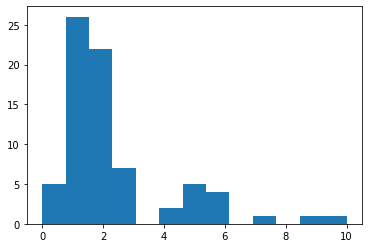

In [20]:
import matplotlib.pyplot as plt

x_pili = np.abs(df_pilH.loc[df_pilH['TotalPili']>0,'piliB_piliD'].values)
print(np.mean(x_pili))
print(np.median(x_pili))
plt.hist(x_pili, bins = 13)
plt.show()

0.71999141999142
1.0


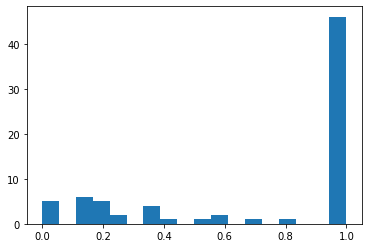

In [21]:
y_pili = np.abs(df_pilH.loc[df_pilH['TotalPili']>0,'piliB_piliD_over_Tot'].values)
print(np.mean(y_pili))
print(np.median(y_pili))
plt.hist(y_pili, bins = 18)
plt.show()

6283.283783783784
4236.0


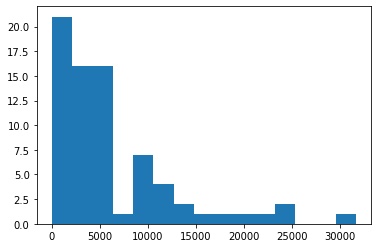

In [27]:
x_fluo = np.abs(df_pilH.loc[df_pilH['TotalPili']>0,'fluoB_fluoD'].values)
print(np.mean(x_fluo))
print(np.median(x_fluo))
plt.hist(x_fluo, bins = 15)
plt.show()

0.07579059860471649
0.053113180166750304


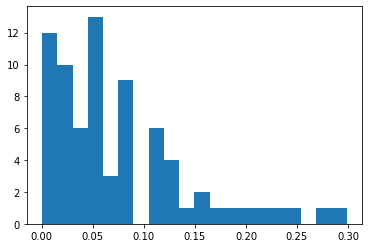

In [30]:
y_fluo = np.abs(df_pilH.loc[df_pilH['TotalPili']>0,'fluoB_fluoD_over_totFluoPole'].values)
print(np.mean(y_fluo))
print(np.median(y_fluo))
plt.hist(y_fluo, bins = 20)
plt.show()

In [31]:
p3 = bokeh.plotting.figure(
        width=600, 
        height=600, 
        x_axis_label='# pili', 
        y_axis_type='linear',
        y_axis_label ='pole fluorescence',
        title=str(df_pilH.Strain.unique()[0])+" pole total fluorescence vs # pili (bootstrap median, 95% CI)"
)
p3.circle(
    x=x_pili,
    y=x_fluo, 
    line_color = 'green',
    fill_color = 'white',
    alpha=0.4,
    #legend = labelsAll[i]
)

bokeh.io.show(p3)

In [25]:
p3 = bokeh.plotting.figure(
        width=600, 
        height=600, 
        x_axis_label='# pili', 
        y_axis_type='linear',
        y_axis_label ='pole fluorescence',
        title=str(df_pilH.Strain.unique()[0])+" pole total fluorescence vs # pili (bootstrap median, 95% CI)"
)
p3.circle(
    x=y_pili,
    y=y_fluo, 
    line_color = 'green',
    fill_color = 'white',
    alpha=0.4,
    #legend = labelsAll[i]
)

bokeh.io.show(p3)